In [1]:
import numpy as np
import h5py
import scipy
from scipy.signal import wiener, medfilt
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
import os
import pickle
%matplotlib inline


# Loading previously fit model

In [2]:
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [3]:
def cubes2img(cubes):
    img = np.zeros([176,96,96])
    count = 0
    for i in range(0,  img.shape[0], tile_size):
        for j in range(0,  img.shape[1], tile_size):
            for z in range(0,  img.shape[2], tile_size):
                for i_k in range(0, tile_size, stride):
                    for j_k in range(0, tile_size, stride):
                        for z_k in range(0,tile_size,stride):
                            img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)] = cubes[count]
                            count = count + 1
    return img

In [4]:
def changeDimension(img):
    a=np.vstack((np.zeros([1,100,100]),img))
    a=a[:,2:-2,2:-2]
    return a


(-0.5, 95.5, 175.5, -0.5)

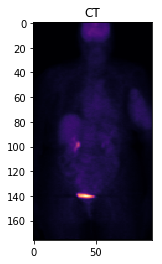

In [5]:
ct_data, pet_data, label_data = [], [], []
z=np.zeros([175,100,100]).astype(int)
num_data = 4
with h5py.File(os.path.join('..','input','lab_petct_vox_5.00mm.h5'),'r') as p_data:
    for ct_img, pet_img, label in zip(p_data['ct_data'].values(),
                                      p_data['pet_data'].values(),
                                      p_data['label_data'].values()):
        
        #a=changeDimension(ct_img)
        ct_data += [changeDimension(ct_img)]
        pet_data += [changeDimension(pet_img)]
        label_data += [changeDimension(label)]
        num_data = num_data - 1
        if num_data == 0:
            break
ct_data = [ct_data[2]]
pet_data = [pet_data[2]]
label_data = [label_data[2]]
fig, ax1 = plt.subplots(1,1)

css=np.sum(pet_data[0],1).squeeze()[::-1,:]
ax1.imshow(css, cmap = 'magma')
ax1.set_title('CT')
ax1.axis('on')

In [6]:
ct_cubes, pet_cubes,lab_cubes = [], [], []
tile_size=16
stride=16
for ct_img, pet_img, label in zip(ct_data, pet_data, label_data):
    for i in range(0,  ct_img.shape[0], tile_size):
        for j in range(0,  ct_img.shape[1], tile_size):
            for z in range(0,  ct_img.shape[2], tile_size):
                for i_k in range(0, tile_size, stride):
                    for j_k in range(0, tile_size, stride):
                        for z_k in range(0,tile_size,stride):
                            ct_cubes += [ct_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            pet_cubes += [pet_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            lab_cubes += [label[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]] 


In [7]:
from sklearn.preprocessing import normalize

def reduceCTCube(cube,axis):
    return np.sum(cube,axis)
    
def reducePETCube(cube,axis):
    cube_array=np.sqrt(np.max(cube,axis))
    where_are_NaNs = np.isnan(cube_array)
    cube_array[where_are_NaNs] = 0.001386386961242742
    return cube_array
    
def reduceLabelCube(cube):
    return(np.mean(cube))

In [8]:
data_tiles, data_labels = [], []

n_ct_cubes = [c_tile for c_tile in ct_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_pet_cubes = [c_tile for c_tile in pet_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_lab_cubes = [c_tile for c_tile in lab_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]

for ct_cube, pet_cube, lab_cube in zip(n_ct_cubes, n_pet_cubes,n_lab_cubes):
    data_tile = []
    for axis in range(3):
        a=reducePETCube(pet_cube, axis).flatten()
        data_tile = np.concatenate([data_tile, a])
    data_tiles += [data_tile]
    data_labels += [reduceLabelCube(lab_cube)]


C:\Users\Himanshu\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


In [9]:
predictions = loaded_model.predict(data_tiles)

# Actual Result

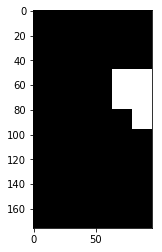

In [10]:
l_img = np.zeros((396,16,16,16))
l_img[np.where(np.array(data_labels) > 0)] = 1
l_img = cubes2img(l_img)
plt.imshow(np.max(l_img,1).squeeze()[::-1,:], cmap = 'bone')
plt.show()


# Predicted Result- Very bad result

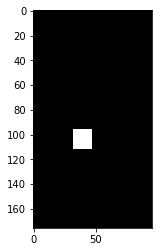

In [11]:
l_img = np.zeros((396,16,16,16))
l_img[np.where(np.array(predictions) > 0)] = 1
l_img = cubes2img(l_img)
plt.imshow(np.max(l_img,1).squeeze()[::-1,:], cmap = 'bone')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(data_labels)>0, np.array(predictions)>0)

array([[386,   1],
       [  9,   0]])

396
(176, 96, 96)


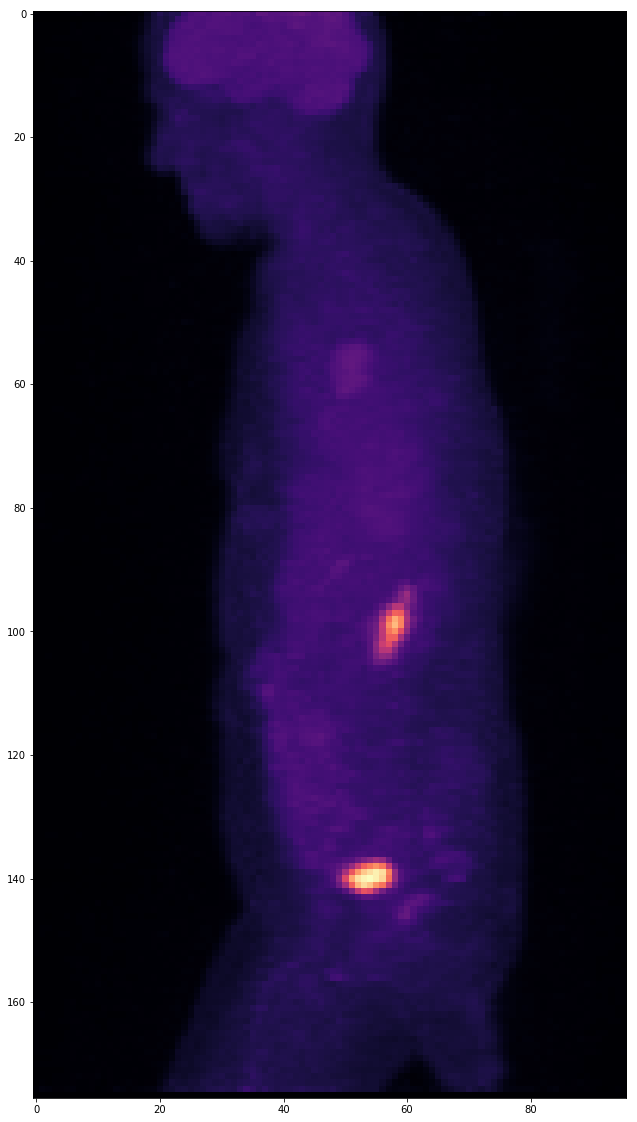

In [27]:
print(len(n_ct_cubes))    
img=cubes2img(n_pet_cubes)
print(np.shape(img))

css=np.sqrt(np.max(img,2)).squeeze()[::-1,:]
plt.figure(figsize = (20,20))
plt.imshow(css, cmap = 'magma')
plt.show()


In [19]:
np.where(np.array(data_labels)!=np.array(predictions))

(array([164, 203, 232, 233, 238, 239, 268, 269, 274, 275], dtype=int64),)

In [20]:
data_tiles[164]

array([ 1.49268362,  1.45912556,  1.45118649,  1.40711348,  1.37967285,
        1.31693323,  1.29966839,  1.32946969,  1.40748425,  1.39697613,
        1.37780769,  1.48938723,  1.42075341,  1.48064473,  1.46945007,
        1.4345648 ,  1.49340796,  1.44221499,  1.47215086,  1.45437054,
        1.45678092,  1.32793093,  1.33928539,  1.36134509,  1.41669244,
        1.48259519,  1.46840502,  1.60909792,  1.47793443,  1.35694252,
        1.45101541,  1.41111465,  1.45921243,  1.52675364,  1.49770383,
        1.49466677,  1.40472083,  1.33712697,  1.42379241,  1.31030794,
        1.36672748,  1.3909063 ,  1.48481491,  1.5454897 ,  1.42257683,
        1.32017131,  1.44593285,  1.43440163,  1.52795586,  1.47914639,
        1.53340343,  1.50409781,  1.34906314,  1.47010717,  1.39525452,
        1.3363375 ,  1.3614255 ,  1.35175748,  1.38043453,  1.4551883 ,
        1.40275616,  1.33733409,  1.3488897 ,  1.34491969,  1.55472263,
        1.66137114,  1.73792066,  1.64014203,  1.35201785,  1.43

In [21]:
data_tiles[165]

array([ 1.29924925,  1.39482466,  1.42164502,  1.46073495,  1.45432144,
        1.36585707,  1.3743533 ,  1.40134988,  1.32396899,  1.23566665,
        1.36076318,  1.55847321,  1.67175663,  1.51753404,  1.45255803,
        1.52028156,  1.39520907,  1.35843607,  1.39303312,  1.47165386,
        1.43382172,  1.38737446,  1.43380246,  1.47473462,  1.31216705,
        1.28034525,  1.30887294,  1.53147831,  1.74259951,  1.48111852,
        1.52822168,  1.58809399,  1.44627719,  1.46334047,  1.39798471,
        1.44827108,  1.37477448,  1.30856942,  1.41020986,  1.4111971 ,
        1.31389445,  1.22905861,  1.2773003 ,  1.41755002,  1.70802829,
        1.51169786,  1.540298  ,  1.72027964,  1.4434037 ,  1.43446507,
        1.41362578,  1.41021469,  1.37367474,  1.35220623,  1.35551313,
        1.29193654,  1.28006587,  1.24295094,  1.28928954,  1.38954915,
        1.57982595,  1.48990287,  1.52707338,  1.65656242,  1.43827315,
        1.43925326,  1.39989014,  1.3963421 ,  1.32439679,  1.32

In [ ]:
css=np.sqrt(np.max(img,2)).squeeze()[::-1,:]
plt.figure(figsize = (20,20))
plt.imshow(css, cmap = 'magma')
plt.show()